In [1]:
# UPDATES!


%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
import keras as K
from keras import callbacks, optimizers
from keras import backend as KB
from keras.engine import Layer
from keras.layers import Activation
from keras.layers import LeakyReLU, Dense, Input, Embedding, Dropout, Reshape, Concatenate # !
from keras.layers import Bidirectional, GRU, Flatten, SpatialDropout1D, Conv1D
from keras.datasets import imdb # probably redundant
from keras.preprocessing import sequence
from keras.models import Model
from keras.utils import to_categorical
from common import vocabulary, utils

import time # !

/home/yeunghoman/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [4]:
print("Tensorflow version:", tf.__version__)
print("Keras version:", K.__version__)

Tensorflow version: 1.4.1
Keras version: 2.1.5


In [2]:
TRAIN_FILE = "../data/conll2003/eng.train"
DEV_FILE = "../data/conll2003/eng.testa"
TEST_FILE = "../data/conll2003/eng.testb"

In [3]:
# NOT PIPELINE
!head -10 {TRAIN_FILE}

-DOCSTART- -X- -X- O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O


In [14]:
# NOT PIPELINE
# this is odd that the B-PER tag doesn't appear... investigate this.
!grep "B-PER" {TRAIN_FILE}

In [4]:
# NOT PIPELINE
def readfile( filename, pos=False):
    '''
    read the conll2003 file
    
    filename(string) - path to conll2003 file (train, test, etc.)
    pos(boolean) - flag if true will include pos tags in returned list
    returns a list of lists of lists corresponding to the words in each sentence
    
    '''
    f = open(filename)
    sentences = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.strip().split(' ')
        word = [splits[0], splits[1], splits[-1]] if pos else [splits[0], splits[-1]]
        sentence.append( word)

    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
    return sentences

In [16]:
# NOT PIPELINE
trainSentences = readfile(TRAIN_FILE, True)

In [31]:
# NOT PIPELINE
trainSentences[:3]

[[['EU', 'NNP', 'I-ORG'],
  ['rejects', 'VBZ', 'O'],
  ['German', 'JJ', 'I-MISC'],
  ['call', 'NN', 'O'],
  ['to', 'TO', 'O'],
  ['boycott', 'VB', 'O'],
  ['British', 'JJ', 'I-MISC'],
  ['lamb', 'NN', 'O'],
  ['.', '.', 'O']],
 [['Peter', 'NNP', 'I-PER'], ['Blackburn', 'NNP', 'I-PER']],
 [['BRUSSELS', 'NNP', 'I-LOC'], ['1996-08-22', 'CD', 'O']]]

In [26]:
# NOT PIPELINE
trainLens = np.array([len(s) for s in trainSentences])
trainLens

array([9, 2, 2, ..., 4, 2, 4])

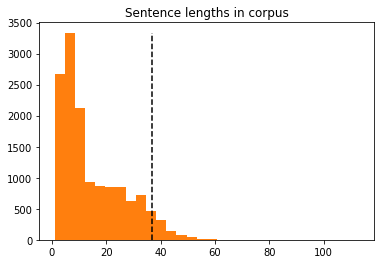

Sentences longer than 37.0 words: 5 %


In [27]:
# NOT PIPELINE
from matplotlib import pyplot as plt
clipPct = 5

maxLen = np.percentile(trainLens, 100 - clipPct)
histLens = plt.hist(trainLens, bins=30)
plt.vlines( maxLen, 0, max(histLens[0]), linestyles="dashed")
plt.title("Sentence lengths in corpus")
plt.hist(trainLens, bins=30)
plt.show()
print( "Sentences longer than", maxLen, "words:", clipPct, "%")

In [30]:
# NOT PIPELINE
print (histLens)
print ("Max sentence length: ", max(trainLens))

(array([  2.66500000e+03,   3.33600000e+03,   2.12800000e+03,
         9.26000000e+02,   8.61000000e+02,   8.54000000e+02,
         8.58000000e+02,   6.27000000e+02,   7.23000000e+02,
         4.59000000e+02,   3.25000000e+02,   1.37000000e+02,
         7.90000000e+01,   3.90000000e+01,   1.00000000e+01,
         9.00000000e+00,   2.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00]), array([   1.        ,    4.73333333,    8.46666667,   12.2       ,
         15.93333333,   19.66666667,   23.4       ,   27.13333333,
         30.86666667,   34.6       ,   38.33333333,   42.06666667,
         45.8       ,   49.53333333,   53.26666667,   57.        ,
         60.73333333,   64.46666667,   68.2       ,   71.93333333,
         75.66666667,   79.4       ,   83.13333333, 

In [32]:
# NOT PIPELINE

# build vocabulary - thank you w266
# -- first attempt, leave in all numbers and maintain case
flatData = [w for w in zip(*utils.flatten(trainSentences))]

# try with lower vocab sizes... 10k, 15k, 20k
vocab = vocabulary.Vocabulary( flatData[0])
posTags = vocabulary.Vocabulary( flatData[1])
nerTags = vocabulary.Vocabulary( flatData[2])

print( (list(vocab.wordset)[:20]))
print( "Vocab size:", vocab.size)
print( (list(posTags.wordset)))
print( (list(nerTags.wordset)))

['LUNCH', 'conversion', '0:10', 'paramedics', 'unwound', '7944', 'billion', 'Carlton', 'socialism', 'Currently', 'Kamio', 'Scout', 'pressed', 'Rain', '32.40', 'forfeited', '11.00', 'consult', 'Pope', 'relegated']
Vocab size: 23626
['NNPS', 'VBD', 'WP', '$', 'JJS', 'NNS', 'POS', 'WP$', 'UH', 'CC', '.', 'NNP', 'EX', 'TO', 'MD', 'WRB', 'NN|SYM', ',', 'RBR', 'PRP', '<s>', 'RP', ':', '<unk>', 'NN', 'VB', 'JJR', 'VBG', 'FW', 'JJ', 'CD', 'VBP', 'RBS', "''", 'PDT', 'IN', ')', 'VBZ', '"', 'RB', '</s>', 'WDT', 'DT', 'PRP$', 'LS', '(', 'VBN', 'SYM']
['</s>', 'O', 'I-LOC', 'B-ORG', 'I-MISC', '<s>', 'B-MISC', 'I-ORG', 'B-LOC', '<unk>', 'I-PER']


In [34]:
# NOT PIPELINE
print (vocab)

In [43]:
flatData[1]

('NNP',
 'VBZ',
 'JJ',
 'NN',
 'TO',
 'VB',
 'JJ',
 'NN',
 '.',
 'NNP',
 'NNP',
 'NNP',
 'CD',
 'DT',
 'NNP',
 'NNP',
 'VBD',
 'IN',
 'NNP',
 'PRP',
 'VBD',
 'IN',
 'JJ',
 'NN',
 'TO',
 'NNS',
 'TO',
 'VB',
 'JJ',
 'NN',
 'IN',
 'NNS',
 'VBP',
 'IN',
 'JJ',
 'NN',
 'NN',
 'MD',
 'VB',
 'VBN',
 'TO',
 'NN',
 '.',
 'NNP',
 'POS',
 'NN',
 'TO',
 'DT',
 'NNP',
 'NNP',
 'POS',
 'JJ',
 'NN',
 'NNP',
 'NNP',
 'VBD',
 'IN',
 'NNP',
 'NNS',
 'MD',
 'VB',
 'NN',
 'IN',
 'NNS',
 'JJ',
 'IN',
 'NNP',
 'IN',
 'DT',
 'JJ',
 'NN',
 'VBD',
 'JJR',
 '.',
 '"',
 'PRP',
 'VBP',
 'RB',
 'VB',
 'DT',
 'JJ',
 'NN',
 'IN',
 'PRP',
 'VBP',
 'RB',
 'VB',
 'DT',
 'NNS',
 'IN',
 'PRP',
 ',',
 '"',
 'DT',
 'NNP',
 'POS',
 'JJ',
 'NN',
 'NNP',
 'NNP',
 'FW',
 'NNP',
 'VBD',
 'DT',
 'NN',
 'NN',
 '.',
 'PRP',
 'VBD',
 'JJ',
 'JJ',
 'NN',
 'VBD',
 'VBN',
 'CC',
 'IN',
 'PRP',
 'VBD',
 'VBN',
 'IN',
 'NN',
 'VBD',
 'VBN',
 'PRP',
 'MD',
 'VB',
 'VBN',
 'IN',
 'DT',
 'NNP',
 'NNP',
 '.',
 'PRP',
 'VBD',
 'DT',
 'NN',


## Data Class !

In [32]:
# UPDATES!


def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print ('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed


def capitalizaion(word):
    """
    check capitalization info for a word
    return 'lowercase' for 'sfsd'
    return 'allCaps' for 'SFSD'
    return 'upperInitial' for 'Sfsd'
    return 'mixedCaps' for 'SfSd'
    return 'noinfo' for '$#%@#' or '12334'
    """
    alphas = [c.isalpha() for c in word] 
    if sum(alphas) != len(word):
        return 'noinfo'
    caps = [char.lower()==char for char in word]
    if sum(caps) == len(word):
        return 'lowercase'
    elif sum(caps) == 0:
        return 'allCaps'
    elif caps[0] == False and sum(caps) == len(word)-1:
        return 'upperInitial'
    elif 0 < sum(caps) < len(word):
        return 'mixedCaps'
    else:
        return 'noinfo'
        


class conll2003Data(object):
    """
    Keep track of data and processing operations for a single CoNLL2003 data file.
    """

    def __init__(self, filePath_train):
        """
        filePath(string): path to a CoNLL2003 raw data file for training the vocabulary
        """
        self.vocab = []
        self.posTags = []
        self.nerTags = []
        self.train_sentences = self.readFile(filePath_train)


    @timeit
    def readFile(self, filePath, verbose=True):
        """
        Read the conll2003 raw data file

        filename(string) - path to conll2003 file (train, test, etc.)
        
        Returns: a list of lists of lists corresponding to the words, pos tags, and ner tags
                 in each sentence

        """
        f = open(filePath)
        sentences = []
        sentence = []
        for line in f:
            if len(line) == 0 or line.startswith("-DOCSTART") or line[0] == '\n':
                if len(sentence) > 0:
                    sentences.append(sentence)
                    sentence = []
                continue
            
            # input format is [ word, pos tag, chunck tag, ner tag]
            # we are ignoring the chunck tag
            splits = line.strip().split(' ')
            word = [utils.canonicalize_word(splits[0]), splits[1], splits[3], capitalizaion(splits[0])]
            sentence.append( word)
        
        # don't forget the last sentence
        if len(sentence) > 0:
            sentences.append(sentence)
            sentence = []
        
        if verbose: 
            print ("----------------------------------------------------")
            print ("reading file from path", str(filePath))
            print ("number of sentences on file =",len(sentences))
            print ("first 5 sentences:")
            print (sentences[:5])

        return sentences


    @timeit
    def buildVocab(self, vocabSize=None, verbose=True, return_vocab_objects=False):
        """
        Builds the vocabulary based on the initial data file
        
        vocabSize(int, default: None-all words) - max number of words to use for vocabulary
                                                  (only used for training)
        verbose(boolean, default: False)        - print extra info
        """    	
        if verbose:
            print ("----------------------------------------------------")
            print ("building vocabulary from TRAINING data...")

        flatData = [w for w in zip(*utils.flatten(self.train_sentences))]

        # remember these vocabs will have the <s>, </s>, and <unk> tags in there
        # sizes need to be interpreted "-3" - consider replacing...
        self.vocab = vocabulary.Vocabulary( flatData[0], size=vocabSize)
        self.posTags = vocabulary.Vocabulary( flatData[1])
        self.nerTags = vocabulary.Vocabulary( flatData[2])
        self.capitalTags = vocabulary.Vocabulary(flatData[3])

        if verbose:
            print ("vocabulary for words, posTags, nerTags built and stored in object")
            print ("vocab size =", vocabSize)
            print ("10 sampled words from vocabulary\n", list(self.vocab.wordset)[:10], "\n")
            print ("number of unique pos Tags in training =", self.posTags.size)
            print ("all posTags used\n", list(self.posTags.wordset), "\n")
            print ("number of unique NER tags in training =", self.nerTags.size)
            print ("all nerTags for prediction", list(self.nerTags.wordset), "\n")
            print ("number of unique capitalization tags in training =", self.capitalTags.size)
            print ('all capitalTags for prediction', list(self.capitalTags.wordset), "\n")

        if return_vocab_objects:
            return self.vocab, self.posTags, self.nerTags, self.capitalTags


    @timeit
    def formatWindowedData(self, sentences, windowLength=9, verbose=False):
        """
        Format the raw data by blocking it into context windows of a fixed length corresponding 
        to the single target NER tag of the central word.
        Make sure to call buildVocab first.
        
        sentences(list of lists of lists) - raw data from the CoNLL2003 dataset
        windowLength(int, default: 9)     - The length of the context window
                    NOTE - windowLength must be odd to have a central word. If itsn't, 1 will be added.
        verbose(boolean, default: False)  - print extra info
        
        Returns: 3 numpy arrays: vocabulary training data windowed and converted to IDs, 
                                 POS tags windowed and converted to IDs,
                                 NER label tags converted to IDs
        """
        if verbose:
            print ("----------------------------------------------------")
            print ("formatting sentences into input windows...")

        if windowLength % 2 == 0 or windowLength == 1:
            raise ValueError("window Length must be an odd number and greater than one.")
    
        pads = windowLength // 2

        # we have a list of lists (sentences) of lists ([word, posTag, nerTag])
        # parse through, pad each sentence with pads open and close tags, then convert to IDs
        vocabIDs = [ self.vocab.words_to_ids( ["<s>"] * pads + [word[0] for word in sent] + ["</s>"] * pads) \
                     for sent in sentences]
        posIDs = [ self.posTags.words_to_ids( ["<s>"] * pads + [word[1] for word in sent] + ["</s>"] * pads) \
                   for sent in sentences]
        capitalIDs = [self.capitalTags.words_to_ids(["<s>"]*pads + [word[3] for word in sent] + ["</s>"]*pads) \
                     for sent in sentences]
        nerIDs = [ self.nerTags.words_to_ids( ["<s>"] * pads + [word[2] for word in sent] + ["</s>"] * pads) \
                   for sent in sentences]
        
        if verbose: 
            print ("STEP 1/2 -- PADDING")
            print ("all sentences padded with {} pads to either end".format(pads))
            print ("vocab idx for first 5 sentences:\n", vocabIDs[:5], "\n")
            print ("pos idx for first 5 sentences:\n", posIDs[:5], "\n")
            print ("ner idx for first 5 sentences:\n", nerIDs[:5], "\n")
            print ("capitalization idx for first 5 sentences: \n", capitalIDs[:5], "\n")
            print ("number of sentences = {}".format(len(vocabIDs)), "\n")

        assert(len(vocabIDs) == len(posIDs) and len(posIDs) == len(nerIDs) == len(capitalIDs))

        if verbose: 
            print ("STEP 2/2 -- WINDOWING")

        # build the data to train on by sliding the window across each sentence
        # at this point, all 3 lists are the same size, so we can run through them all at once
        featsVocab, featsPOS, featsNER, featsCAPITAL = [], [], [], []
        for sentID in range( len(vocabIDs)):
            sent = vocabIDs[sentID]
            sentPOS = posIDs[sentID]
            sentNER = nerIDs[sentID]
            sentCAPITAL = capitalIDs[sentID]
            
            for ID in range( len(sent) - windowLength + 1):
                featsVocab.append( sent[ID:ID + windowLength])
                featsPOS.append( sentPOS[ID:ID + windowLength])
                featsCAPITAL.append(sentCAPITAL[ID:ID + windowLength])
                featsNER.append( sentNER[ID + windowLength // 2])
                
        if verbose:
            print ("sample windows:")
            for i in range(3):
                print ("Vocab for window {}".format(i))
                print (featsVocab[i])
                print (self.vocab.ids_to_words(featsVocab[i]))
                print ("PoS tags for window {}".format(i))
                print (featsPOS[i])
                print (self.posTags.ids_to_words(featsPOS[i]))
                print ("Capitalization tags for window {}".format(i))
                print (featsCAPITAL[i])
                print (self.capitalTags.ids_to_words(featsCAPITAL[i]))
                print ("NER tags for center word")
                print (featsNER[i])
                print (self.nerTags.ids_to_words([featsNER[i]]),"\n")
                
            print ("rows of vocab features = {}".format(len(featsVocab)))
            print ("rows of PoS features = {}".format(len(featsVocab)))
            print ("rows of Capitalization features = {}".format(len(featsCAPITAL)))
            print ("rows of NER features = {}".format(len(featsNER)))
            
            print ("numpy feature arrays are returned")

        assert(len(featsVocab) == len(featsVocab) == len(featsNER) == len(featsCAPITAL))
        return np.array(featsVocab), np.array(featsPOS), np.array(featsCAPITAL), np.array(featsNER) 

## Load the Data

In [33]:
# UPDATES!

windowLength = 9
testNumSents = 5000

# Use training set to build vocab here
vocabData = conll2003Data(TRAIN_FILE)
vocabData.buildVocab( vocabSize=20000)

# Format training data
trainX, trainX_pos, trainX_capitals, trainY  = vocabData.formatWindowedData( vocabData.train_sentences, 
                                                  windowLength=windowLength,
                                                  verbose=True)

# read in dev data
devSents = vocabData.readFile( DEV_FILE)
# Format dev data
devX, devX_pos, devX_capitals, devY = vocabData.formatWindowedData( devSents, 
                                              windowLength=windowLength,
                                              verbose=True)

# read in the test data
testSents = vocabData.readFile( TEST_FILE)
# Format test data
testX, testX_pos, testX_capitals, testY = vocabData.formatWindowedData( testSents, 
                                                windowLength=windowLength,
                                                verbose=True)

----------------------------------------------------
reading file from path ../data/conll2003/eng.train
number of sentences on file = 14041
first 5 sentences:
[[['eu', 'NNP', 'I-ORG', 'allCaps'], ['rejects', 'VBZ', 'O', 'lowercase'], ['german', 'JJ', 'I-MISC', 'upperInitial'], ['call', 'NN', 'O', 'lowercase'], ['to', 'TO', 'O', 'lowercase'], ['boycott', 'VB', 'O', 'lowercase'], ['british', 'JJ', 'I-MISC', 'upperInitial'], ['lamb', 'NN', 'O', 'lowercase'], ['.', '.', 'O', 'noinfo']], [['peter', 'NNP', 'I-PER', 'upperInitial'], ['blackburn', 'NNP', 'I-PER', 'upperInitial']], [['brussels', 'NNP', 'I-LOC', 'allCaps'], ['DGDGDGDG-DGDG-DGDG', 'CD', 'O', 'noinfo']], [['the', 'DT', 'O', 'upperInitial'], ['european', 'NNP', 'I-ORG', 'upperInitial'], ['commission', 'NNP', 'I-ORG', 'upperInitial'], ['said', 'VBD', 'O', 'lowercase'], ['on', 'IN', 'O', 'lowercase'], ['thursday', 'NNP', 'O', 'upperInitial'], ['it', 'PRP', 'O', 'lowercase'], ['disagreed', 'VBD', 'O', 'lowercase'], ['with', 'IN', 'O',

sample windows:
Vocab for window 0
[0, 0, 0, 0, 279, 20, 2331, 246, 76]
['<s>', '<s>', '<s>', '<s>', 'cricket', '-', 'leicestershire', 'take', 'over']
PoS tags for window 0
[0, 0, 0, 0, 3, 23, 3, 3, 6]
['<s>', '<s>', '<s>', '<s>', 'NNP', ':', 'NNP', 'NNP', 'IN']
Capitalization tags for window 0
[0, 0, 0, 0, 6, 4, 6, 6, 6]
['<s>', '<s>', '<s>', '<s>', 'allCaps', 'noinfo', 'allCaps', 'allCaps', 'allCaps']
NER tags for center word
3
['O'] 

Vocab for window 1
[0, 0, 0, 279, 20, 2331, 246, 76, 21]
['<s>', '<s>', '<s>', 'cricket', '-', 'leicestershire', 'take', 'over', 'at']
PoS tags for window 1
[0, 0, 0, 3, 23, 3, 3, 6, 3]
['<s>', '<s>', '<s>', 'NNP', ':', 'NNP', 'NNP', 'IN', 'NNP']
Capitalization tags for window 1
[0, 0, 0, 6, 4, 6, 6, 6, 6]
['<s>', '<s>', '<s>', 'allCaps', 'noinfo', 'allCaps', 'allCaps', 'allCaps', 'allCaps']
NER tags for center word
3
['O'] 

Vocab for window 2
[0, 0, 279, 20, 2331, 246, 76, 21, 358]
['<s>', '<s>', 'cricket', '-', 'leicestershire', 'take', 'over', 'at'

## Investigate NER tags

In [47]:
# NOT PIPELINE
print (trainY[:5])
print (trainX_pos[:5])
print (trainX[:5])

[5 3 7 3 3]
[[ 0  0  0  0  3 22  8  4 17]
 [ 0  0  0  3 22  8  4 17 13]
 [ 0  0  3 22  8  4 17 13  8]
 [ 0  3 22  8  4 17 13  8  4]
 [ 3 22  8  4 17 13  8  4 11]]
[[    0     0     0     0   959 11985   235   764     8]
 [    0     0     0   959 11985   235   764     8  4149]
 [    0     0   959 11985   235   764     8  4149   211]
 [    0   959 11985   235   764     8  4149   211  6184]
 [  959 11985   235   764     8  4149   211  6184     3]]


In [48]:
# NOT PIPELINE
print (trainY.shape)
print (trainX_pos.shape)
print (trainX.shape)

(203621,)
(203621, 9)
(203621, 9)


In [43]:
# NOT PIPELINE
print ("training NER labels")
print (set(trainY))
print (vocabData.nerTags.ids_to_words(set(trainY)))
print ("\ndev NER labels")
print (set(devY))
print (vocabData.nerTags.ids_to_words(set(devY)))
print ("\ntest NER labels")
print (set(testY))
print (vocabData.nerTags.ids_to_words(set(testY)))

training NER labels
{3, 4, 5, 6, 7, 8, 9, 10}
['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']

dev NER labels
{3, 4, 5, 6, 7, 8}
['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC']

test NER labels
{3, 4, 5, 6, 7, 8, 9, 10}
['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']


In [44]:
# NOT PIPELINE
vocabData.nerTags.unigram_counts

Counter({'B-LOC': 11,
         'B-MISC': 37,
         'B-ORG': 24,
         'I-LOC': 8286,
         'I-MISC': 4556,
         'I-ORG': 10001,
         'I-PER': 11128,
         'O': 169578})

In [46]:
# NOT PIPELINE
from collections import Counter
bc = Counter()
a = []
flatX = trainX.flatten()
flatY = trainY.flatten()
for j, i in enumerate(flatY):
    if i == 10:
        a += [j]
        #print(vocabData.vocab.id_to_word[flatX[j]])
    bc[int(i)] += 1
    
for j in a:
    print( vocabData.vocab.id_to_word[trainX[j][4]], vocabData.vocab.ids_to_words(trainX[j]))
    print( vocabData.nerTags.id_to_word[flatY[j]], vocabData.nerTags.ids_to_words(flatY[j-4:j+5]))

Israel ['retain', 'the', 'Golan', 'Heights', 'Israel', 'captured', 'from', 'Syria', 'in']
B-LOC ['O', 'O', 'I-LOC', 'I-LOC', 'B-LOC', 'O', 'O', 'I-LOC', 'O']
MT ['<s>', '<s>', '<s>', 'Billings', 'MT', '4.62', 'up', '.01', '4.50']
B-LOC ['O', 'O', 'O', 'I-LOC', 'B-LOC', 'O', 'O', 'O', 'O']
MT ['<s>', '<s>', '<s>', 'Havre', 'MT', '4.54', 'dn', '.10', '---']
B-LOC ['O', 'O', 'O', 'I-LOC', 'B-LOC', 'O', 'O', 'O', 'O']
MT ['<s>', '<s>', '<s>', 'Rudyard', 'MT', '4.54', 'dn', '.10', '---']
B-LOC ['O', 'O', 'O', 'I-LOC', 'B-LOC', 'O', 'O', 'O', 'O']
MT ['<s>', '<s>', 'Wolf', 'Point', 'MT', '4.41', 'dn', '.10', '---']
B-LOC ['O', 'O', 'I-LOC', 'I-LOC', 'B-LOC', 'O', 'O', 'O', 'O']
OR ['<s>', '<s>', '<s>', 'Portland', 'OR', '5.60', 'up', '.02', '5.1700']
B-LOC ['O', 'O', 'O', 'I-LOC', 'B-LOC', 'O', 'O', 'O', 'O']
OR ['<s>', '<s>', '<s>', 'Pendleton', 'OR', '---', '---', '---', '---']
B-LOC ['O', 'O', 'O', 'I-LOC', 'B-LOC', 'O', 'O', 'O', 'O']
WA ['<s>', '<s>', 'Coolee', 'City', 'WA', '5.13', 'up

## Build the model

In [5]:
# capsule layers from Xifeng Guo 
# https://github.com/XifengGuo/CapsNet-Keras
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

In [6]:
# UPDATES!

# encoding 1-hot for ner targets
trainY_cat = to_categorical(trainY.astype('float32'))
devY_cat = to_categorical(devY.astype('float32'), num_classes=trainY_cat.shape[1])
testY_cat = to_categorical(testY.astype('float32'), num_classes=trainY_cat.shape[1])

trainY_cat = np.array(list(map( lambda i: np.array(i[3:], dtype=np.float), trainY_cat)), dtype=np.float)
devY_cat = np.array(list(map( lambda i: np.array(i[3:], dtype=np.float), devY_cat)), dtype=np.float)
testY_cat = np.array(list(map( lambda i: np.array(i[3:], dtype=np.float), testY_cat)), dtype=np.float)

In [7]:
# NEW!

# encoding 1-hot for pos tags
trainX_pos_cat = to_categorical(trainX_pos.astype('float32'))
devX_pos_cat = to_categorical(devX_pos.astype('float32'), num_classes=trainX_pos_cat.shape[2]) 
testX_pos_cat = to_categorical(testX_pos.astype('float32'), num_classes=trainX_pos_cat.shape[2])

trainX_pos_cat = np.array(list(map( lambda i: np.array(i[:,3:], dtype=np.float), trainX_pos_cat)), dtype=np.float)
devX_pos_cat = np.array(list(map( lambda i: np.array(i[:,3:], dtype=np.float), devX_pos_cat)), dtype=np.float)
testX_pos_cat = np.array(list(map( lambda i: np.array(i[:,3:], dtype=np.float), testX_pos_cat)), dtype=np.float)

In [8]:
# NEW!

# encoding 1-hot for capitalization info  ("allCaps", "upperInitial", "lowercase", "mixedCaps", "noinfo")
trainX_capitals_cat = to_categorical(trainX_capitals.astype('float32'))
devX_capitals_cat = to_categorical(devX_capitals.astype('float32'), num_classes=trainX_capitals_cat.shape[2]) 
testX_capitals_cat = to_categorical(testX_capitals.astype('float32'), num_classes=trainX_capitals_cat.shape[2])

trainX_capitals_cat = np.array(list(map( lambda i: np.array(i[:,3:], dtype=np.float), trainX_capitals_cat)), dtype=np.float)
devX_capitals_cat = np.array(list(map( lambda i: np.array(i[:,3:], dtype=np.float), devX_capitals_cat)), dtype=np.float)
testX_capitals_cat = np.array(list(map( lambda i: np.array(i[:,3:], dtype=np.float), testX_capitals_cat)), dtype=np.float)

In [10]:
# UPDATES!

# Define hyperparameters
max_features = vocabData.vocab.size # 20000
maxlen = trainX.shape[1] # 9  --> window size
poslen = trainX_pos_cat.shape[2] # 45 pos classes   #! NEW
capitallen = trainX_capitals_cat.shape[2] # 5 capitalization classes #! NEW
ner_classes = trainY_cat.shape[1] # 8 
embed_dim = 50 # word embedding size
num_routing = 3 

save_dir = './result'
batch_size = 100
debug = 2
epochs = 5
dropout_p = 0.25
embed_dropout = 0.25
lam_recon = 0.0005

#Load train and test data
#(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_features)
#x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
#x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [28]:
#construct embedding matrix

vocabData.vocab.size

17748

In [13]:
# UPDATES!

# input
x = Input(shape=(maxlen,))
x_pos = Input(shape=(maxlen,poslen))
x_capital = Input(shape=(maxlen, capitallen))
print ("x", x.get_shape())
print ("x_pos", x_pos.get_shape())
print ("x_capital", x_capital.get_shape())

# feed input into embedding layer
embed = Embedding(max_features, embed_dim, input_length=maxlen, embeddings_initializer="random_uniform" )(x)
# embed = Embedding(max_features, embed_dim, weights=[embedding_matrix],input_length=maxlen, trainable=False)(x)
print ("embed", embed.get_shape())

# concat embeddings with pos Tags here
embed_concat_pos = Concatenate(axis=-1)([embed, x_pos, x_capital])
print ("embed_concat_pos", embed_concat_pos.get_shape())

# feed embeddings into conv1
conv1 = Conv1D( filters=256, kernel_size=3, strides=1, padding='valid', activation='relu', name='conv1')(embed_concat_pos)
print ("conv1", conv1.get_shape())

# make primary capsules
primarycaps = PrimaryCap(embed, dim_capsule=8, n_channels=32, kernel_size=3, strides=1, padding='valid')
print ("primarycaps", primarycaps.get_shape())

# make ner capsules
ner_caps = CapsuleLayer(num_capsule=ner_classes, dim_capsule=16, routings=num_routing, name='nercaps')(primarycaps)
print ("ner_caps", ner_caps.get_shape())

# replace each ner capsuel with its length
out_caps = Length(name='out_caps')(ner_caps)
print ("out_caps", out_caps.get_shape())

capsmodel = Model(inputs=[x, x_pos], outputs=[out_caps])

x (?, 9)
x_pos (?, 9, 45)
x_capital (?, 9, 5)
embed (?, 9, 50)
embed_concat_pos (?, 9, 100)
conv1 (?, 7, 256)
primarycaps (?, ?, 8)
ner_caps (?, 8, 16)
out_caps (?, 8)


In [ ]:
#Saving weights and logging
log = callbacks.CSVLogger(save_dir + '/log.csv')
tb = callbacks.TensorBoard(log_dir=save_dir + '/tensorboard-logs', 
                           batch_size=batch_size, histogram_freq=debug)
checkpoint = callbacks.ModelCheckpoint(save_dir + '/weights-{epoch:02d}.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True, 
                                       verbose=1)

def margin_loss(y_true, y_pred):
    L = y_true*KB.square(KB.maximum(0., 0.9-y_pred)) + 0.5*(1-y_tue)*KB.square(KB.maximum(0., y_pred-0.1))
    return KB.mean(KB.sum(L,1))

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

capsmodel.summary()